### Relevant links

https://www.kaggle.com/c/competitive-data-science-predict-future-sales

### Imports

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline 
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 147 ms


In [211]:
from scripts.imports import *
import scripts.kaggle_data as kd
from scripts.utility import *

time: 17.3 ms


In [4]:
pd.options.display.max_rows = 4000
pd.set_option('display.max_columns', 999)
pd.options.mode.chained_assignment = None

time: 25 ms


### Getting data

In [ ]:
current_path = os.getcwd()
data_dir_path = os.path.join(current_path,"data")

if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

print(data_dir_path) #Never print

In [ ]:
kd.download_data('competitive-data-science-predict-future-sales',current_path)

In [5]:
#Listify files to download
all_data_files = os.listdir('data/') #Getting all files in data folder in a list
all_data_files = [x for x in all_data_files if x.endswith('.csv')] #Removing .ipynb files
all_data_files = [remove_from_right(x,4) for x in all_data_files] #Removing .csvs
all_data_files

['shops',
 'items',
 'submission_v1',
 'item_categories',
 'sales_train',
 'sample_submission',
 'test']

time: 154 ms


In [6]:
for i in all_data_files:
    print(i + "=" + f"kd.read_data('data/','csv','{i}')")
    print("")
    exec(i + "=" + f"kd.read_data('data/','csv','{i}')")
    exec(f"shape = {i}.shape")
    print(f"Shape of {i}: ", shape)
    exec(f"data_types = {i}.dtypes")
    print("")
    print(f"Data types in {i}: \n \n ", data_types)
    print("---------------------")

shops=kd.read_data('data/','csv','shops')

Shape of shops:  (60, 2)

Data types in shops: 
 
  shop_name    object
shop_id       int64
dtype: object
---------------------
items=kd.read_data('data/','csv','items')

Shape of items:  (22170, 3)

Data types in items: 
 
  item_name           object
item_id              int64
item_category_id     int64
dtype: object
---------------------
submission_v1=kd.read_data('data/','csv','submission_v1')

Shape of submission_v1:  (214200, 2)

Data types in submission_v1: 
 
  ID                  int64
item_cnt_month    float64
dtype: object
---------------------
item_categories=kd.read_data('data/','csv','item_categories')

Shape of item_categories:  (84, 2)

Data types in item_categories: 
 
  item_category_name    object
item_category_id       int64
dtype: object
---------------------
sales_train=kd.read_data('data/','csv','sales_train')

Shape of sales_train:  (2935849, 6)

Data types in sales_train: 
 
  date               object
date_block_num  

In [7]:
save_test = test

time: 18 ms


### Testing data

#### Structural checks

In [ ]:
#Unique data values
#sales_train >> \
#select(X.date,X.date_block_num) >> \
#distinct(X.date,X.date_block_num) >> \
#arrange(X.date_block_num, ascending = True) 

#Finding
#We have daily sales data as well

In [ ]:
#Check for missing value in train data
#for k in sales_train.columns:
    #display_all(sales_train >> summarise_each([null_percent],k))

#### See headers of all data

In [ ]:
sales_train >> head

In [ ]:
shops >> head

In [ ]:
items >> head

In [ ]:
item_categories >> head

In [ ]:
test >> head

### Feature engineering

#### Create features

In [8]:
# Add dates to training data
sales_train = add_datepart(df = sales_train, custom_date_format = '%d.%m.%Y',field_name = 'date', drop = False)
#Assignment is done to avoid printing the dataframe
raw_data = sales_train

time: 10.3 s


In [148]:
raw_data = raw_data >> mutate(item_id = X.item_id.astype(str), shop_id = X.shop_id.astype(str)) >> \
mutate(item_cnt_day = if_else(X.item_cnt_day < 0, 0, X.item_cnt_day),
      item_cnt_day_return = if_else(X.item_cnt_day < 0, -X.item_cnt_day,0))

time: 4.46 s


In [151]:
#raw_data >> select(X.date_block_num,X.Month,X.Year) >> \
#distinct(X.date_block_num,X.Month,X.Year) >> arrange(X.date_block_num)

#Will use date block num as a unique month idetifier from now on

time: 31.1 ms


In [212]:
#Parameters in this notebook
train_month = 32
valid_month = 33
test_month = 34
months_to_consider = 24

custom_parameters = {
 'sum_values': None,
 'mean_change': None,
 'linear_trend': [{"attr": "slope"}],
 'skewness': None,
 'median': None,
 'mean': None,
 'count_above_mean': None,
 'count_below_mean': None,
 'maximum': None,
 'minimum': None,
 'number_crossing_m': [{"m":0}]
        }
    
#custom_parameters = EfficientFCParameters()

time: 23.5 ms


In [213]:
train_raw_data = raw_data >> mask((X.date_block_num >= train_month -32) & (X.date_block_num <= train_month) ) >> \
mutate(date_flag = if_else(X.date_block_num == train_month,'y','x'))

valid_raw_data = raw_data >> mask((X.date_block_num >= valid_month -32) & (X.date_block_num <= valid_month) ) >> \
mutate(date_flag = if_else(X.date_block_num == valid_month,'y','x'))

test_raw_data = raw_data >> mask((X.date_block_num >= test_month -32) & (X.date_block_num <= test_month) ) >> \
mutate(date_flag = if_else(X.date_block_num == test_month,'y','x'))

time: 10.4 s


In [214]:
train = create_model_data(train_raw_data) 
valid = create_model_data(valid_raw_data) 

test = save_test >> mutate(item_id = X.item_id.astype(str), shop_id = X.shop_id.astype(str)) >> select(~X.ID) >> \
mutate(composite = X.item_id + X.shop_id)
print(test.shape)

(417004, 4)
(408799, 4)
(214200, 3)
time: 6.78 s


In [215]:
train = add_prediction_month_feature(train,train_raw_data,9)
valid = add_prediction_month_feature(valid,valid_raw_data,10)
test = add_prediction_month_feature(test,test_raw_data,11)

time: 17.5 s


In [216]:
item_train = create_sparse_data(train_raw_data,train,['item_id'],train_month-months_to_consider,train_month)
item_valid = create_sparse_data(valid_raw_data,valid,['item_id'],valid_month-months_to_consider,valid_month)
item_test = create_sparse_data(test_raw_data,test,['item_id'],test_month-months_to_consider,test_month)

shop_train = create_sparse_data(train_raw_data,train,['shop_id'],train_month-months_to_consider,train_month)
shop_valid = create_sparse_data(valid_raw_data,valid,['shop_id'],valid_month-months_to_consider,valid_month)
shop_test = create_sparse_data(test_raw_data,test,['shop_id'],test_month-months_to_consider,test_month)
    
is_train = create_sparse_data(train_raw_data,train,['item_id','shop_id'],train_month-months_to_consider,train_month)
is_valid = create_sparse_data(valid_raw_data,valid,['item_id','shop_id'],valid_month-months_to_consider,valid_month)
is_test = create_sparse_data(test_raw_data,test,['item_id','shop_id'],test_month-months_to_consider,test_month)

item_train_ts = ts_features(item_train,custom_parameters)
item_valid_ts = ts_features(item_valid,custom_parameters)
item_test_ts = ts_features(item_test,custom_parameters)

shop_train_ts = ts_features(shop_train,custom_parameters)
shop_valid_ts = ts_features(shop_valid,custom_parameters)
shop_test_ts = ts_features(shop_test,custom_parameters)
    
is_train_ts = ts_features(is_train,custom_parameters)
is_valid_ts = ts_features(is_valid,custom_parameters)
is_test_ts = ts_features(is_test,custom_parameters)
    
train = apply_ts_features(train,is_train_ts,'composite')
valid = apply_ts_features(valid,is_valid_ts,'composite')
test = apply_ts_features(test,is_test_ts,'composite')
    
train = apply_ts_features(train,item_train_ts,'item_id')
valid = apply_ts_features(valid,item_valid_ts,'item_id')
test = apply_ts_features(test,item_test_ts,'item_id')
    
train = apply_ts_features(train,shop_train_ts,'shop_id')
valid = apply_ts_features(valid,shop_valid_ts,'shop_id')
test = apply_ts_features(test,shop_test_ts,'shop_id')

Feature Extraction: 100%|██████████| 80/80 [01:16<00:00,  1.07s/it]


time: 16min 45s


In [217]:
train = apply_lag(train,is_train,['item_id','shop_id'],12)
valid = apply_lag(valid,is_valid,['item_id','shop_id'],12)
test = apply_lag(test,is_test,['item_id','shop_id'],12)

time: 1min 6s


In [218]:
train = item_presence(train,train_raw_data)
valid = item_presence(valid,valid_raw_data)
test = item_presence(test,test_raw_data)

train = item_presence_3M(train,train_raw_data,train_month)
valid = item_presence_3M(valid,valid_raw_data,valid_month)
test = item_presence_3M(test,test_raw_data,test_month)

time: 1min 24s


In [286]:
train = item_category_size(train,items)
valid = item_category_size(valid,items)
test = item_category_size(test,items)

time: 4.04 s


In [220]:
train = price(train,train_raw_data)
valid = price(valid,valid_raw_data)
test = price(test,test_raw_data)

time: 1min 9s


In [142]:
#Not actually needed, hence commented out
#Plot histograms or get min max to see -99999 isfar away from range present in data
#train.fillna(value=-99999,inplace = True) 
#valid.fillna(value=-99999,inplace = True)
#test.fillna(value=-99999,inplace = True)

time: 33.6 ms


In [ ]:
#advanced_describe(train)

### EDA

#### Check distribution

In [163]:
check = dd_summarise(raw_data,['date_block_num','item_id','shop_id'],'item_cnt_day','sum')

time: 3.84 s


In [167]:
check[check.item_cnt_day > 20].shape[0]/check.shape[0]

0.0071312092790860124

time: 28 ms


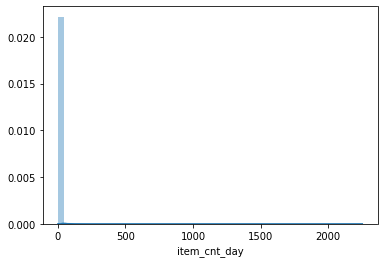

time: 735 ms


In [228]:
sns.distplot(check.item_cnt_day[check.item_cnt_day>0])

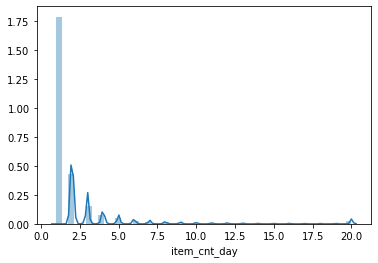

time: 636 ms


In [229]:
sns.distplot(train.item_cnt_day[train.item_cnt_day>0])

#### Check trends

In [ ]:
train_sampled >> head

In [197]:
sparsed_data = create_sparse_data(train_raw_data >> mask(X.item_id =='2808' ,X.shop_id == '25'),
                                  train >> mask(X.item_id =='2808' ,X.shop_id == '25'),
                                  ['item_id','shop_id'],0,32)

time: 1.68 s


In [198]:
for_plot = sparsed_data >> mutate(composite = "D " + X.item_id + X.shop_id)
#is_ = for_plot >> distinct(X.item_id) >> select(X.item_id) >> sample(5)
#for_plot = for_plot >> inner_join(is_,by = ['item_id'])
for_plot.shape

(31, 6)

time: 31 ms


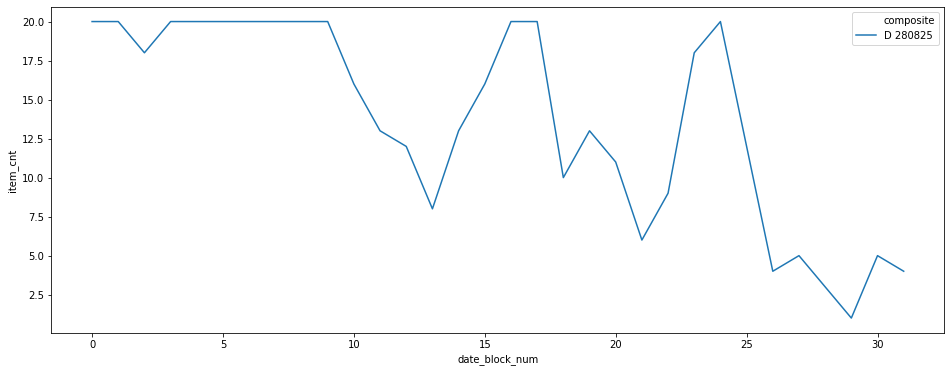

time: 445 ms


In [199]:
plt.figure(figsize=(16, 6))
ax =  sns.lineplot(x="date_block_num", y="item_cnt",hue = "composite", data=for_plot)

In [200]:
#for_plot

time: 29.8 ms


In [209]:
#raw_data >>  mask(X.item_id =='2808',X.shop_id == '25',X.date_block_num >= 29)

time: 286 ms


#### Check test data

In [279]:
#test >> head

time: 32.9 ms


### Modelling

#### Baseline 
Predict the most recent sales data point

In [ ]:
#Monthly sales
monthly_sales = dd_summarise(sales_train, ['shop_id','item_id','date_block_num'],'item_cnt_day', 'sum')

In [ ]:
#Max month block
filtered_sales_train = sales_train >> mask(X.date_block_num > 30)
max_month = dd_summarise(filtered_sales_train , ['shop_id','item_id'],'date_block_num', 'max')

In [ ]:
#Get recent sales
predictions = monthly_sales >> inner_join(max_month, by =['shop_id','item_id','date_block_num'])

In [ ]:
#Create the submission df
test_submission = test >> left_join(predictions, by = ['shop_id','item_id']) >> select(X.ID,X.item_cnt_day)
test_submission = test_submission >> rename(item_cnt_month = X.item_cnt_day) >> \
mutate(item_cnt_month = if_else(X.item_cnt_month.isnull(),0,X.item_cnt_month))

In [ ]:
#Check the data type of submission file
test_submission.dtypes

#### RF

In [27]:
m = RandomForestRegressor(n_estimators=600, min_samples_leaf=10, max_features=0.8, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train.values.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
                      oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

time: 27.6 s


In [28]:
print_score(m,x_train,y_train,x_valid,y_valid)

[2.0572205267852417, 3.981513643204398, 0.33846112857190247, 0.048031470684468114, 0.23061168572188717]
time: 8.29 s


In [29]:
round_print_score(m,x_train,y_train,x_valid,y_valid)

[2.061480050837262, 3.983451540296412, 0.33846112857190247, 0.048031470684468114, 0.23061168572188717]
time: 8.43 s


In [ ]:
plot_fi(rf_feat_importance(m,x_train))

In [ ]:
valid_predictions = m.predict(x_valid)
valid_predictions = valid >> mutate(item_cnt_day_predicted = valid_predictions)

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x=valid_predictions.item_cnt_day_predicted, y=valid_predictions.item_cnt_day, 
                  kind="hex", color="k")

In [ ]:
valid_predictions >> mask(X.item_cnt_day_predicted > 5 , X.item_cnt_day == 0) >> head

In [ ]:
#m = RandomForestRegressor(n_estimators=300, min_samples_leaf=10, max_features=0.5, n_jobs=-1, oob_score=True)
#m.fit(x_valid, y_valid.values.ravel())

#### Xgboost

In [301]:
##data preparation
ind_columns = train.columns.to_list()

list_to_remove = ['shop_id','item_id','item_cnt_day']
ind_columns = remove_elements(ind_columns, list_to_remove )

dep_coloumns = ["item_cnt_day"]

cont_vars = train.head(5).select_dtypes(include= [np.number]).columns.to_list()
cont_vars = remove_elements(cont_vars, ['item_cnt_day'])

cat_vars = train.head(5).select_dtypes(include= [object]).columns.to_list()
list_to_remove = ['shop_id','item_id']

cat_vars = remove_elements(cat_vars, list_to_remove)

train_sampled = train #>> sample(50000)

x_train = train_sampled[ind_columns]
y_train = train_sampled[dep_coloumns]

x_test = test[ind_columns]

x_valid = valid[ind_columns]
y_valid = valid[dep_coloumns]

print("Shape of training data: ", x_train.shape)
print("Shape of validation data: ", x_valid.shape)
print("Shape of test data: ", x_test.shape)

xg_train = xgb.DMatrix(x_train, label = y_train)
xg_test = xgb.DMatrix(x_test)
xg_valid = xgb.DMatrix(x_valid, label = y_valid)

Shape of training data:  (417004, 91)
Shape of validation data:  (408799, 91)
Shape of test data:  (214200, 91)
time: 3.14 s


In [302]:
#Model
param = {'max_depth':8,
         'eta':0.05, # learning rate
         'gamma':2,
         'min_child_weight':10,
         'objective':'reg:squarederror',
         'eval_metric': 'rmse' ,
         'colsample_bytree': 0.6}

watchlist  = [(xg_valid, 'valid')]
num_round = 1000

xgm = xgb.train(param, xg_train, num_round, evals = watchlist, early_stopping_rounds=10)

[0]	valid-rmse:0.919192
Will train until valid-rmse hasn't improved in 10 rounds.
[1]	valid-rmse:0.895548
[2]	valid-rmse:0.8739
[3]	valid-rmse:0.85483
[4]	valid-rmse:0.837201
[5]	valid-rmse:0.820281
[6]	valid-rmse:0.805389
[7]	valid-rmse:0.791461
[8]	valid-rmse:0.7796
[9]	valid-rmse:0.768773
[10]	valid-rmse:0.758258
[11]	valid-rmse:0.748702
[12]	valid-rmse:0.740389
[13]	valid-rmse:0.732998
[14]	valid-rmse:0.726082
[15]	valid-rmse:0.719857
[16]	valid-rmse:0.714874
[17]	valid-rmse:0.710319
[18]	valid-rmse:0.706573
[19]	valid-rmse:0.702495
[20]	valid-rmse:0.699569
[21]	valid-rmse:0.696849
[22]	valid-rmse:0.694359
[23]	valid-rmse:0.692032
[24]	valid-rmse:0.689645
[25]	valid-rmse:0.68802
[26]	valid-rmse:0.68662
[27]	valid-rmse:0.68569
[28]	valid-rmse:0.684083
[29]	valid-rmse:0.683211
[30]	valid-rmse:0.682173
[31]	valid-rmse:0.681386
[32]	valid-rmse:0.680748
[33]	valid-rmse:0.680393
[34]	valid-rmse:0.680403
[35]	valid-rmse:0.680028
[36]	valid-rmse:0.680108
[37]	valid-rmse:0.679602
[38]	valid

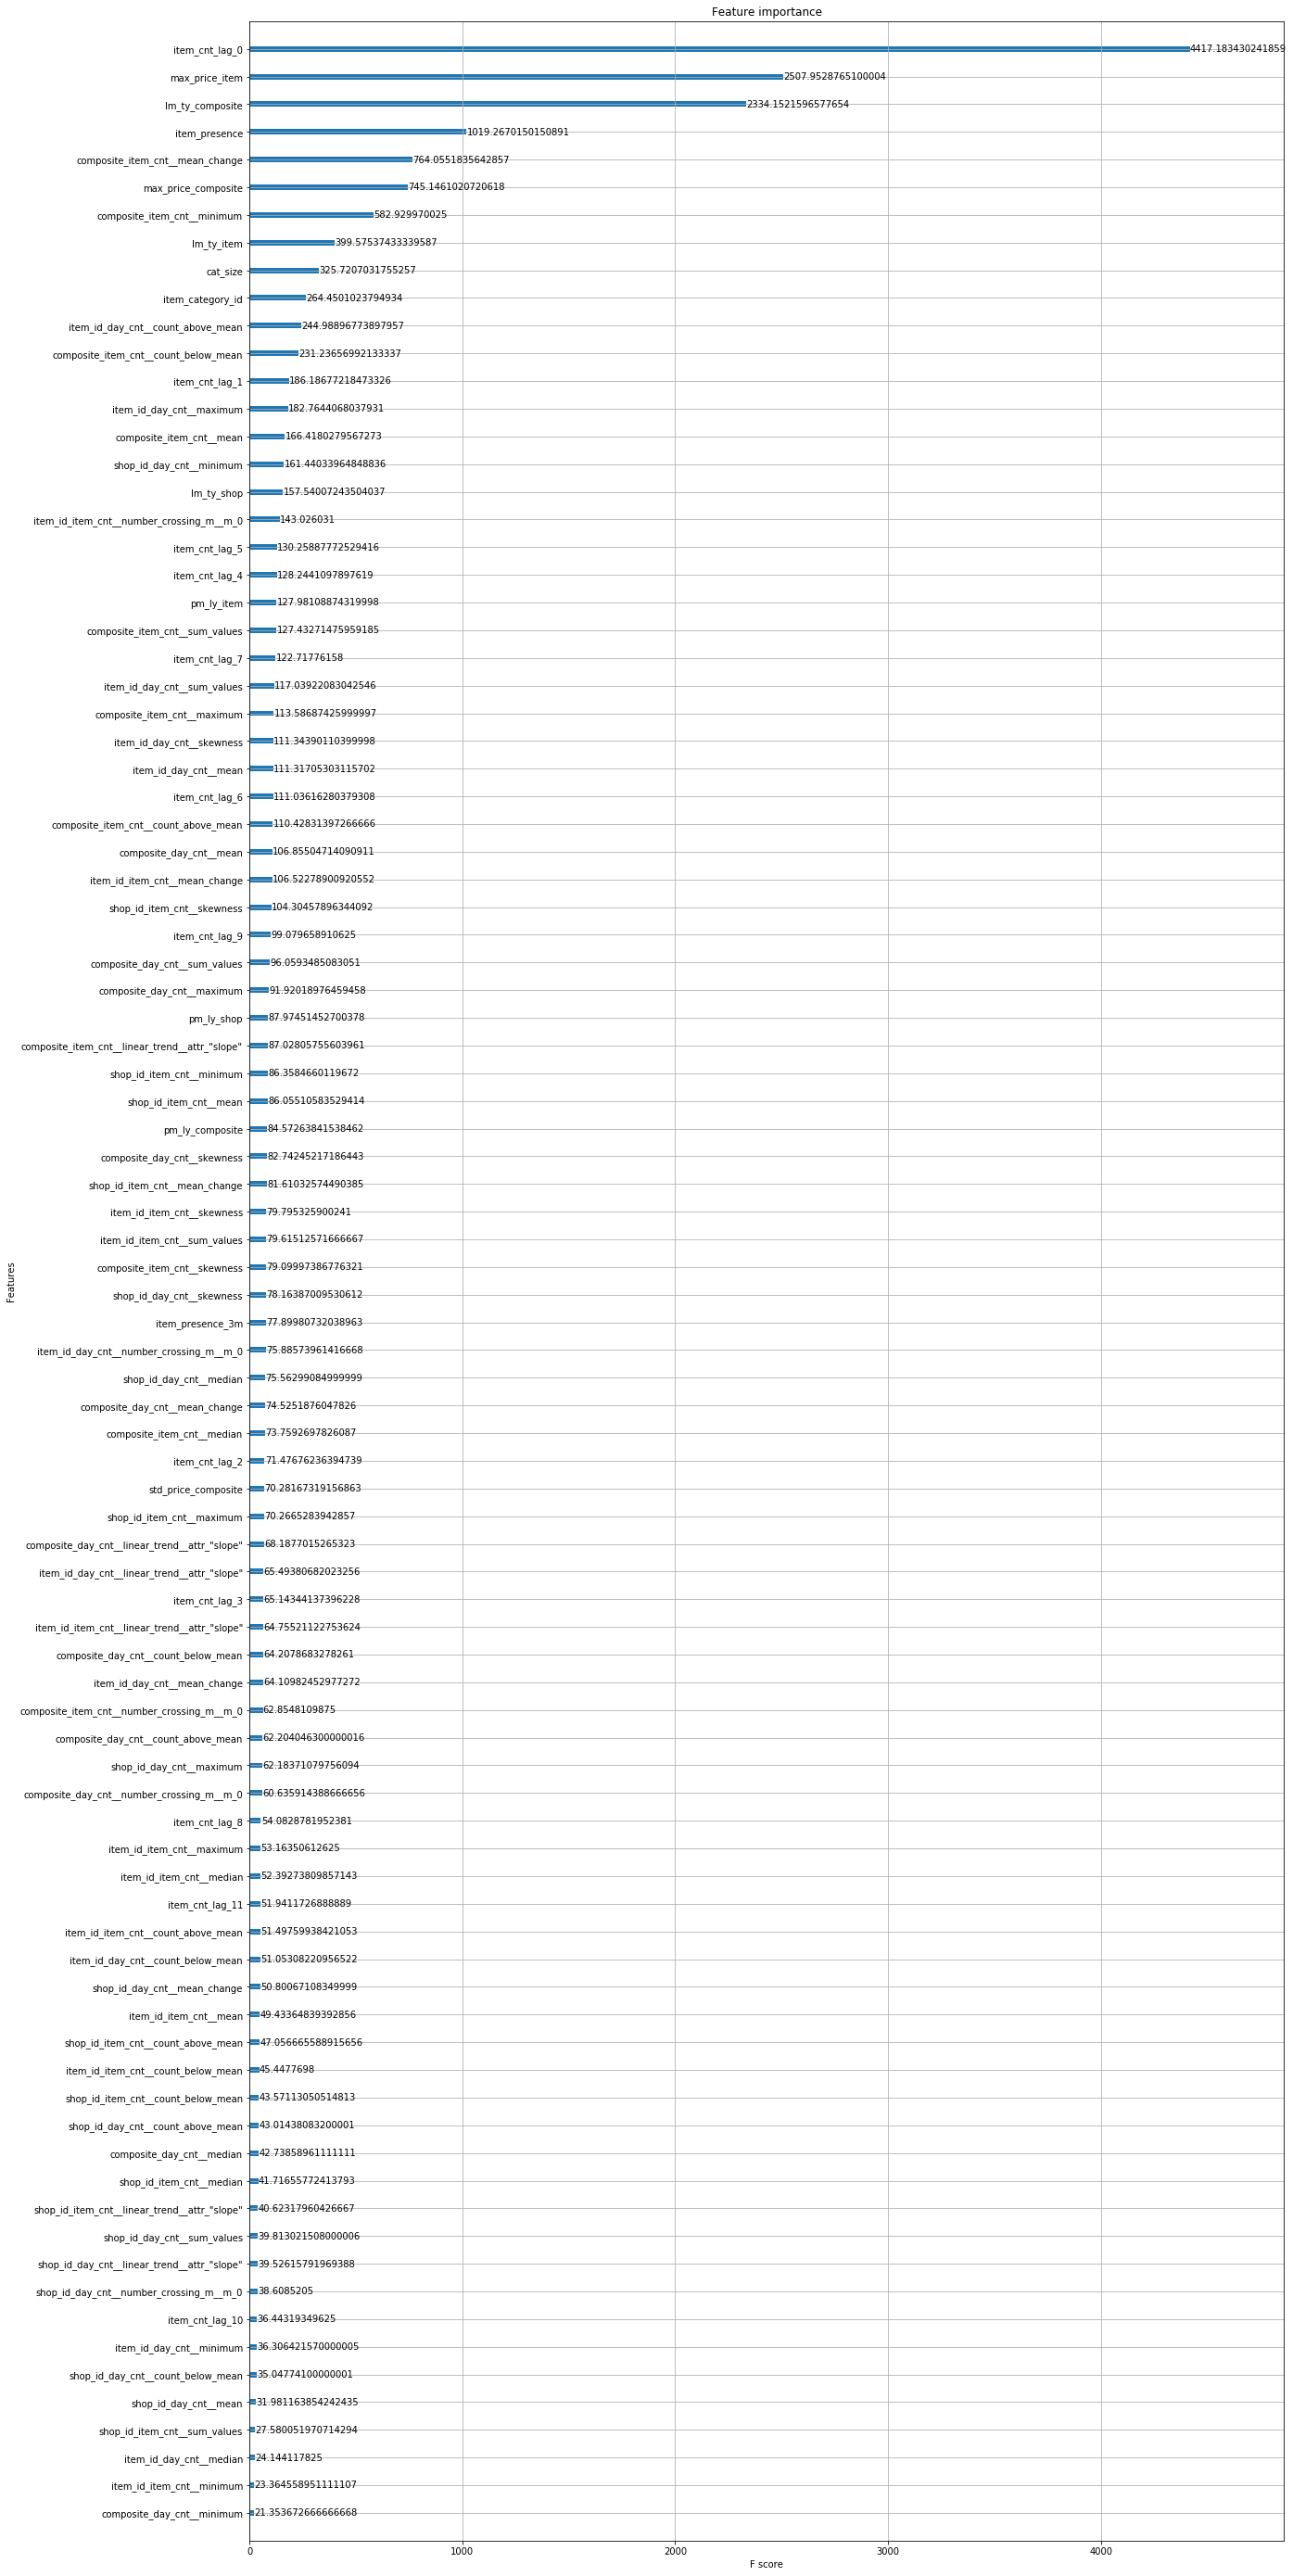

time: 4.57 s


In [303]:
my_plot_importance(xgm,(20,50),importance_type='gain')

In [304]:
#RMSE in validation data
rmse(xgm.predict(xg_valid),y_valid.values.ravel())

0.6802136831788872

time: 37.8 ms


In [305]:
#RMSE in train data
rmse(xgm.predict(xg_train),y_train.values.ravel())

0.4874361128361369

time: 35.5 ms


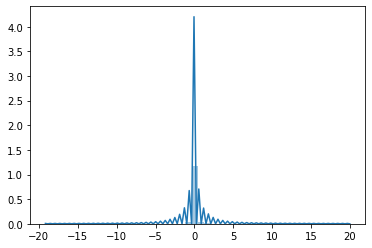

time: 1.48 s


In [276]:
valid_predictions = xgm.predict(xg_valid)
valid_predictions = valid >> mutate(item_cnt_day_predicted = valid_predictions) >> \
mutate(errors = (X.item_cnt_day - X.item_cnt_day_predicted))

vp = valid_predictions

sns.distplot(vp.item_cnt_day - vp.item_cnt_day_predicted)

In [277]:
vp >> mask(X.errors > 19) >> head(3)

,shop_id,item_id,item_cnt_day,pm_ly_composite,pm_ly_item,pm_ly_shop,lm_ty_composite,lm_ty_item,lm_ty_shop,composite_day_cnt__count_above_mean,composite_day_cnt__count_below_mean,"composite_day_cnt__linear_trend__attr_""slope""",composite_day_cnt__maximum,composite_day_cnt__mean,composite_day_cnt__mean_change,composite_day_cnt__median,composite_day_cnt__minimum,composite_day_cnt__number_crossing_m__m_0,composite_day_cnt__skewness,composite_day_cnt__sum_values,composite_item_cnt__count_above_mean,composite_item_cnt__count_below_mean,"composite_item_cnt__linear_trend__attr_""slope""",composite_item_cnt__maximum,composite_item_cnt__mean,composite_item_cnt__mean_change,composite_item_cnt__median,composite_item_cnt__minimum,composite_item_cnt__number_crossing_m__m_0,composite_item_cnt__skewness,composite_item_cnt__sum_values,item_id_day_cnt__count_above_mean,item_id_day_cnt__count_below_mean,"item_id_day_cnt__linear_trend__attr_""slope""",item_id_day_cnt__maximum,item_id_day_cnt__mean,item_id_day_cnt__mean_change,item_id_day_cnt__median,item_id_day_cnt__minimum,item_id_day_cnt__number_crossing_m__m_0,item_id_day_cnt__skewness,item_id_day_cnt__sum_values,item_id_item_cnt__count_above_mean,item_id_item_cnt__count_below_mean,"item_id_item_cnt__linear_trend__attr_""slope""",item_id_item_cnt__maximum,item_id_item_cnt__mean,item_id_item_cnt__mean_change,item_id_item_cnt__median,item_id_item_cnt__minimum,item_id_item_cnt__number_crossing_m__m_0,item_id_item_cnt__skewness,item_id_item_cnt__sum_values,shop_id_day_cnt__count_above_mean,shop_id_day_cnt__count_below_mean,"shop_id_day_cnt__linear_trend__attr_""slope""",shop_id_day_cnt__maximum,shop_id_day_cnt__mean,shop_id_day_cnt__mean_change,shop_id_day_cnt__median,shop_id_day_cnt__minimum,shop_id_day_cnt__number_crossing_m__m_0,shop_id_day_cnt__skewness,shop_id_day_cnt__sum_values,shop_id_item_cnt__count_above_mean,shop_id_item_cnt__count_below_mean,"shop_id_item_cnt__linear_trend__attr_""slope""",shop_id_item_cnt__maximum,shop_id_item_cnt__mean,shop_id_item_cnt__mean_change,shop_id_item_cnt__median,shop_id_item_cnt__minimum,shop_id_item_cnt__number_crossing_m__m_0,shop_id_item_cnt__skewness,shop_id_item_cnt__sum_values,item_cnt_lag_0,item_cnt_lag_1,item_cnt_lag_2,item_cnt_lag_3,item_cnt_lag_4,item_cnt_lag_5,item_cnt_lag_6,item_cnt_lag_7,item_cnt_lag_8,item_cnt_lag_9,item_cnt_lag_10,item_cnt_lag_11,item_presence,item_presence_3m,cat_size,max_price_composite,std_price_composite,max_price_item,item_cnt_day_predicted,errors
136309,55,6936,20.0,0.0,0.0,4229.0,1.0,1.0,6867.0,4.0,20.0,-0.009130,2.0,0.208333,0.043478,0.0,0.0,7.0,2.539278,5.0,4.0,20.0,-0.016522,3.0,0.25,0.043478,0.0,0.0,7.0,3.344474,6.0,4.0,20.0,-0.009130,2.0,0.208333,0.043478,0.0,0.0,7.0,2.539278,5.0,4.0,20.0,-0.016522,3.0,0.25,0.043478,0.0,0.0,7.0,3.344474,6.0,12.0,12.0,31.076957,2042.0,1256.375,30.478261,1252.0,730.0,0.0,0.568219,30153.0,8.0,16.0,130.677391,6867.0,2396.333333,258.73913,1820.0,916.0,0.0,1.660352,57512.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1125,249.0,91.246657,249.0,0.247332,19.752668
136425,55,2403,20.0,0.0,0.0,4229.0,0.0,0.0,6867.0,7.0,17.0,0.015652,4.0,0.500000,0.000000,0.0,0.0,10.0,2.433659,12.0,7.0,17.0,-0.016522,7.0,0.75,0.000000,0.0,0.0,10.0,2.913802,18.0,7.0,17.0,0.015652,4.0,0.500000,0.000000,0.0,0.0,10.0,2.433659,12.0,7.0,17.0,-0.016522,7.0,0.75,0.000000,0.0,0.0,10.0,2.913802,18.0,12.0,12.0,31.076957,2042.0,1256.375,30.478261,1252.0,730.0,0.0,0.568219,30153.0,8.0,16.0,130.677391,6867.0,2396.333333,258.73913,1820.0,916.0,0.0,1.660352,57512.0,0.0,2.0,0.0,0.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1125,797.0,279.420724,797.0,0.457369,19.542631
157058,55,2404,20.0,1.0,1.0,4229.0,0.0,0.0,6867.0,5.0,19.0,-0.023478,2.0,0.250000,0.000000,0.0,0.0,8.0,2.131014,6.0,5.0,19.0,-0.023478,2.0,0.25,0.000000,0.0,0.0,8.0,2.131014,6.0,5.0,19.0,-0.023478,2.0,0.250000,0.000000,0.0,0.0,8.0,2.131014,6.0,5.0,19.0,-0.023478,2.0,0.25,0.000000,0.0,0.0,8.0,2.131014,6.0,12.0,12.0,31.076957,2042.0,1256.375,30.478261

time: 761 ms


In [263]:
error_boundary = 100

vpc = vp >> mutate(item_cnt_day_predicted = if_else(X.errors > error_boundary,X.item_cnt_day,X.item_cnt_day_predicted))
rmse(vpc.item_cnt_day_predicted,vp.item_cnt_day)

0.6973615443490492

time: 706 ms


In [300]:
# #Model
# param = {'max_depth':8,
#          'eta':0.05, # learning rate
#          'gamma':2,
#          'min_child_weight':10,
#          'objective':'reg:squarederror',
#          'eval_metric': 'rmse' ,
#          'colsample_bytree': 0.6}

# num_round = 39

# xgm = xgb.train(param, xg_valid, num_round)

time: 26.7 ms


In [299]:
#RMSE in validation data
#rmse(xgm.predict(xg_valid),y_valid.values.ravel())

time: 26.4 ms


In [264]:
# f = "gain"
# #xgm.get_score(importance_type= f)

# cols_to_keep = []
# num_of_ind_cols = 15
# for index, value in  xgm.get_score(importance_type= f).items():
#     cols_to_keep.append(index)
#     if len(cols_to_keep) >=num_of_ind_cols:
#         break

time: 28.4 ms


In [265]:
# train_sampled = train #>> sample(50000)

# x_train = train_sampled[cols_to_keep]
# y_train = train_sampled[dep_coloumns]

# x_test = test[cols_to_keep]

# x_valid = valid[cols_to_keep]
# y_valid = valid[dep_coloumns]

# xg_train = xgb.DMatrix(x_train, label = y_train)
# xg_test = xgb.DMatrix(x_test)
# xg_valid = xgb.DMatrix(x_valid, label = y_valid)

time: 25.3 ms


In [266]:
# #Retrain model
# param = {'max_depth':10,
#          'eta':0.2, # learning rate
#          'gamma':0,
#          'min_child_weight':10,
#          'objective':'reg:squarederror',
#          'eval_metric': 'rmse' ,
#          'colsample_bytree': 0.6}

# watchlist  = [(xg_valid, 'valid')]
# num_round = 1000

# xgm = xgb.train(param, xg_train, num_round, evals = watchlist, early_stopping_rounds=10)

time: 26.4 ms


### Submission

#### Heuristics

In [ ]:
#Heuristics based
test_submission.to_csv('data/submission_v1.csv', index=False)

#### RF

In [ ]:
#RF model
test_predictions = m.predict(x_test)
test_predictions.shape

In [ ]:
#Create the submission df
test_submission = save_test >> mutate(item_cnt_day = test_predictions)
test_submission = test_submission >> rename(item_cnt_month = X.item_cnt_day) >> drop(X.item_id,X.shop_id)

In [ ]:
test_submission.to_csv('data/submission_v1.csv', index=False)

#### XGBoost

In [306]:
test_predictions = xgm.predict(xg_test)
test_predictions.shape

(214200,)

time: 214 ms


In [307]:
test_submission = save_test >> mutate(item_cnt_day = test_predictions)
test_submission = test_submission >> rename(item_cnt_month = X.item_cnt_day) >> drop(X.item_id,X.shop_id)

time: 45.1 ms


In [308]:
test_submission.to_csv('data/submission__xgb_v2.csv', index=False)

time: 2.15 s


### Unit tests